<img src="Callysto_Notebook-Banner_Top_06.06.18.jpg"/>

## Exam Scheduling with Graph Theory

In [1]:
#Running this cell displays a button to toggle hidden code
#From: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/

from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }
  
  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

This notebook takes data containing student ID numbers and what classes they take in order to create an optimal (minimum number of days) exam schedule with no conflicts. The conditions for this schedule are:

* There are two sessions for exams on each day - AM and PM.
* No student will write two exams on the same day.
* The exam space is limited to 150 students at any time.

This notebook works with data where column 1 contains the grade of the student, column 2 contains student numbers, and column 3 contains class names.

### Exam Scheduling Code

In [2]:
'''
Setting up the tools we'll be using in this notebook:
'''

import networkx as nx
import grinpy as gp
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from collections import OrderedDict

from OptimalGraphColoring import optimal_colorings

%matplotlib inline

In [3]:
'''
Reading the data into the notebook:
'''

#Opening excel file of data:
data = pd.read_excel('Input Data.xlsx', header = None)

#Putting the data into a pandas dataframe:
data_df = pd.DataFrame(data)
data_df.columns =['Grade','Student ID','Class']

#Displaying the data:
display(HTML(data_df.to_html(index=False)))

Grade,Student ID,Class
12,603,Calculus12
12,603,Law12
12,630,Calculus12
12,630,History12
12,630,Law12
12,685,Calculus12
12,685,Chemistry12
12,797,BiologyAnatomyPhysiology12
12,890,BiologyAnatomyPhysiology12
12,890,History12


In [4]:
'''
Creating a dictionary that lists each student and their classes:
'''

#Getting the list of unique students:
students = data.iloc[:, 1].tolist()
students = set(students)

#Creating a dictionary that will be in the form: {student1 : [class1, class2], student2 : [class2, class4] ...}
student_dictionary = {}

#Iterates through each row in the data:
for row in data.itertuples():
    
    #If this row is a student not yet added to the dictionary:
    if row[2] not in student_dictionary:
        
        #Add this student and the class for this row
        student_dictionary[row[2]] = [row[3]]
            
    #If the student already has a dictionary entry:
    else:
        
        #Add the class to the value list:
        student_dictionary[row[2]].append(row[3])
        
#Converting student_dictionary to a pandas dataframe:
student_data = pd.DataFrame([(k, v) for k, v in student_dictionary.items()])
student_data.columns =['Student ID','Classes']

#Displaying the dataframe:
display(HTML(student_data.to_html(index=False)))

Student ID,Classes
603,"[Calculus12, Law12]"
630,"[Calculus12, History12, Law12]"
685,"[Calculus12, Chemistry12]"
797,[BiologyAnatomyPhysiology12]
890,"[BiologyAnatomyPhysiology12, History12, Law12]"
902,"[FoundationsofMathematics12, Geology12, Law12]"
924,"[History12, Law12]"
933,"[FoundationsofMathematics12, History12]"
943,"[History12, Law12]"
951,"[Calculus12, Geology12, Law12]"


In [5]:
'''
Creating a dictionary that lists each class and the number of students in that class:
'''

#Getting the list of unique classes
classes = data.iloc[:, 2].tolist()
classes = set(classes)

#Create a dictionary that will be in the form: {class1: number of students in class1, ...}
class_dictionary = {}

#Iterates through each row in the data:
for row in data.itertuples():
    
    #If this row is a class not yet added to the dictionary:
    if row[3] not in class_dictionary:
        
        #Add one to the number of students in this class:
        class_dictionary[row[3]] = 1
        
    #If the student already has a dictionary entry:
    else:
        
        #Add one to the number of students in this class:
        class_dictionary[row[3]] += 1
        
#Converting class_dictionary to a pandas dataframe:
class_data = pd.DataFrame([(k, v) for k, v in class_dictionary.items()])
class_data.columns =['Class','Number of Students']

#Displaying the dataframe:
display(HTML(class_data.to_html(index=False)))

Class,Number of Students
Calculus12,71
Law12,57
History12,48
Chemistry12,52
BiologyAnatomyPhysiology12,43
FoundationsofMathematics12,18
Geology12,14
PreCalculus12,54
Physics12,34
BiologyLifeSciences11Enriched,12


In [6]:
'''
Creating the conflict graph, and counting the number of nodes and edges:
'''

#Creating graph G
G = nx.Graph()

#Adding each unique class as a node in the graph
for item in classes:
    G.add_node(item)
    
#Iterates through the dictionary of students, adding conflict edges between all the classes each student has:
for student in student_dictionary:
    
    #Iterates through all pairs of classes for the student:
    for x in range(0, len(student_dictionary[student])):
        for y in range (x+1, len(student_dictionary[student])):
            
            #Creates edge for conflict:
            G.add_edge(student_dictionary[student][x], student_dictionary[student][y])
            
#Finding number of nodes and edges in the conflict graph
node_count = G.number_of_nodes()
edge_count = G.number_of_edges()

G_data = {'Nodes': [node_count], 'Edges': [edge_count]}

G_df = pd.DataFrame(G_data)

#Displaying the dataframe:
display(HTML(G_df.to_html(index=False)))

Nodes,Edges
29,149


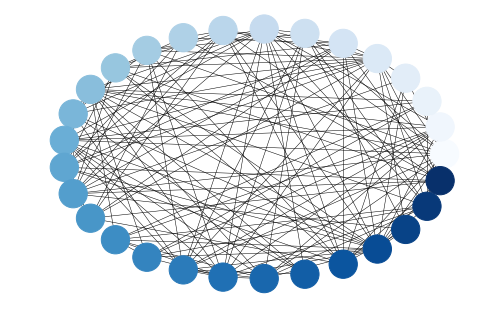

In [7]:
'''
Draws the conflict graph:
'''

#Each node is a class, each edge is a scheduling conflict.
nx.draw_circular(G, with_labels=False, width = .5, node_color=range(29), node_size=800, cmap=plt.cm.Blues)

In [8]:
'''
Finds a possible graph colouring (not final). Colors are named 0, 1, 2, etc.
'''

sample_color = nx.greedy_color(G, strategy = 'random_sequential')

#Converting the colouring to a pandas dataframe:
color_data = pd.DataFrame([(k, v) for k, v in sample_color.items()])
color_data.columns =['Class','Colour']

#Displaying the dataframe:
display(HTML(color_data.to_html(index=False)))

Class,Colour
Chemistry11,0
Geology12,0
Mathematics9,0
BiologyLifeSciences11,1
Physics12,0
Chemistry11Enriched,2
History12,3
PreCalculus11,4
PreCalculus12,4
PreCalculus11Accelerated,0


In [9]:
'''
Computes and displays the final schedule:
'''

#Finding the chromatic number:
chro_num = gp.chromatic_number(G)

#The final solution will go into these lists:
final_solution_AM = []
final_solution_PM = []

#This variable is for the while loop below. If it is set to True, the loop will run.
#If it is set to False by the time the loop is completed, that means a working solution has been found.
#If it is set to True by the time the loop is completed, a solution was not found, and the loop will run again.
run = True

#This loop applies the random-greedy coloring algorithm until all conditions are met and a solution is found:
while run == True:
    
    #Resetting variables:
    final_solution_AM = []
    final_solution_PM = []
    run = False
    
    #Tries a random-greedy algorithm for coloring the graph:
    color = nx.greedy_color(G, strategy = 'random_sequential')

    #Checks that generated coloring has chromatic number of colors, sets loop to run again if it doesn't:
    for key in color:
        if color[key] >= chro_num:
            run = True
    
    #Checks that no single color has more than 300 students total taking an exam, sets loop to run again if failed:
    if run == False:
        
        student_count = []
        
        #Sets up student_count to be the appropriate size:
        for x in range(0, chro_num):
            student_count.append(0)
            
        for key in color:            
            student_count[color[key]] += class_dictionary[key]
            
        for x in student_count:
            if x >= 300:
                run = True
    
    
    #Tries to fill the AM/PM slots so that no more than 150 students are writing at a time:
    if run == False:
        
        #Setting up counts for the number of students in the gym during each time slot:
        student_count_AM = []
        student_count_PM = []
        
        #Setting up lists of classes for the solution (AM and PM slots), as well as the student count lists
        # so that they have one entry for every day.
        #The index will represent the day number (eg. the first set of classes will be for the first day, etc.)
        for x in range(0, chro_num):
            final_solution_AM.append([])
            final_solution_PM.append([])
            student_count_AM.append(0)
            student_count_PM.append(0)
        
        #Iterates through all the classes on a given day (or a given color),
        # in order to sort them into the AM and PM sessions:
        for x in range(0, chro_num): 
            for key in color:
                if color[key] == x:
                    
                    #Adds the class to the solution in the AM slot, if there is still room for it (less than 150 students):
                    if student_count_AM[x] + class_dictionary[key] <= 150:
                        
                        student_count_AM[x] += class_dictionary[key]
                        final_solution_AM[x].append(key)
                    
                    #If the AM session is full, the class is added to the PM slot:
                    else:
                        student_count_PM[x] += class_dictionary[key]
                        final_solution_PM[x].append(key)
            
            #If the PM session now has more than 150 students, this solution doesn't work, and the loop resets to try again:
            if student_count_PM[x] > 150:
                run = True            
            
            
#The rest of the code puts the schedule into a pandas dataframe, and applies some formatting:    
day_col = []
session_col = []
class_col = []
students_col = []

for day in range(0, chro_num):
    
    for class_ in final_solution_AM[day]:
        day_col.append("Day " + str(day+1) + ": " + str(student_count_AM[day]) + " / " + str(student_count_PM[day]) + " students")
        session_col.append("AM")
        class_col.append(class_)
        students_col.append(class_dictionary[class_])
    
    for class_ in final_solution_PM[day]:
        day_col.append("Day " + str(day+1) + ": " + str(student_count_AM[day]) + " / " + str(student_count_PM[day]) + " students")
        session_col.append("PM")
        class_col.append(class_)
        students_col.append(class_dictionary[class_])

d = {
    'Day': day_col,
    'Session': session_col,
    'Class': class_col,     
    'Students': students_col}

df = pd.DataFrame(d,columns=['Day','Session','Class','Students'])
df1=df.set_index(['Day', 'Session'])

df1

Class  Students
Day                       Session                                         
Day 1: 139 / 103 students AM                   Science10Enriched        22
                          AM                        Mathematics9        69
                          AM                           History12        48
                          PM                     SocialStudies11        40
                          PM                           Science10        63
Day 2: 136 / 75 students  AM                      SocialStudies9       124
                          AM          FoundationsofMathematics11        12
                          PM                               Law12        57
                          PM            PreCalculus12Accelerated        18
Day 3: 142 / 89 students  AM                         Chemistry11        25
                          AM                            English9       117
                          PM                          Calculus12        71
                          PM          FoundationsofMathematics12        18
Day 4: 79 / 124 students  AM          BiologyAnatomyPhysiology12        43
                          AM       BiologyLifeSciences11Enriched        12
                          AM               BiologyLifeSciences11        24
                          PM                            Science9       124
Day 5: 110 / 56 students  AM                            Spanish9        58
                          AM                         Chemistry12        52
                          PM                 Chemistry11Enriched        56
Day 6: 130 / 123 students AM         FoundationsofMathPreCalc.10       109
                          AM            PreCalculus11Accelerated        21
                          PM                       PreCalculus12        54
                          PM                       PreCalculus11        69
Day 7: 142 / 35 students  AM                     French9Enriched        17
                          AM                           Physics12        34
                          AM                           Physics11        77
                          AM                           Geology12        14
                          PM                             French9        35

<img src="Callysto_Notebook-Banners_Bottom_06.06.18.jpg"/>